https://www.freecodecamp.org/news/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d/
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf
https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/
https://danieltakeshi.github.io/2018/06/28/a2c-a3c/
https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/
https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/blob/master/a2c_ppo_acktr/algo/a2c_acktr.py
https://github.com/higgsfield/RL-Adventure-2

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import random
import ale_py
import gymnasium as gym

In [100]:
# ----------------------------
# Device setup
# ----------------------------
def get_device():
    """Select available device (CUDA, MPS for Apple, or CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # macOS Metal
        device = torch.device("mps")
    elif torch.version.hip is not None and torch.cuda.is_available():
        device = torch.device("cuda")  # AMD ROCm usually appears as CUDA device
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

In [101]:
# ----------------------------
# Seeding for reproducibility
# ----------------------------
def set_seed(seed):
    """Sets seed for reproducibility across libraries and devices."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [102]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [103]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [104]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()

In [105]:
def train_episode(env, policy, optimizer, gamma, device):
    """Train policy for one episode."""            
    policy.train()
    log_prob_actions, rewards, values = [], [], []
    done = False
    state, _ = env.reset()
    while not done:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_pred, value_pred = policy(state)                
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        
        next_state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(dist.log_prob(action))
        rewards.append(reward)
        values.append(value_pred.squeeze(0))
        state = next_state
    
    log_prob_actions = torch.stack(log_prob_actions)
    values = torch.cat(values)
    
    returns = calculate_returns(rewards, gamma, device, True)
    advantages = calculate_advantages(returns, values, False)    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, sum(rewards)

In [106]:
# ----------------------------
# Training and evaluation
# ----------------------------
def calculate_returns(rewards, gamma, device, normalize=True):
    """Compute discounted returns for an episode."""
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [107]:
def calculate_advantages(returns, values, normalize = True):
    advantages = returns - values.detach()
    if normalize:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    return advantages

In [108]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):
    """Compute loss and update policy and value parameters."""    
    policy_loss = -(advantages * log_prob_actions).sum()    
    value_loss = F.smooth_l1_loss(returns, values).sum()
    loss = policy_loss + value_loss;
    optimizer.zero_grad()
    loss.backward()
    # policy_loss.backward()
    # value_loss.backward()
    optimizer.step()
    return policy_loss.item(), value_loss.item()

In [109]:
def evaluate(env, policy, device):
    """Evaluate policy (greedy)."""        
    policy.eval()
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action_logits, _ = policy(state_tensor)
            action = torch.argmax(F.softmax(action_logits, dim=-1)).item()
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward
        state = next_state
        
    return total_reward

In [110]:
train_env = gym.make('LunarLander-v3', render_mode="rgb_array")
test_env = gym.make('LunarLander-v3', render_mode="rgb_array")

SEED = 1234
set_seed(SEED)
train_env.reset(seed=SEED) # Seed the environment upon reset
test_env.reset(seed=SEED+1) # Seed the environment upon reset

device = get_device()
# device = torch.device("cpu")

INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = test_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic).to(device)
policy.apply(init_weights)

LEARNING_RATE = 0.0005
optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

MAX_EPISODES = 1500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    policy_loss, value_loss, train_reward = train_episode(train_env, policy, optimizer, DISCOUNT_FACTOR, device)
    test_reward = evaluate(test_env, policy, device)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        print(f'Reached reward threshold in {episode} episodes')
        break

print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')


Using device: cuda
| Episode:  10 | Mean Train Rewards:  -279.0 | Mean Test Rewards:  -307.0 |
| Episode:  20 | Mean Train Rewards:  -233.1 | Mean Test Rewards:  -350.2 |
| Episode:  30 | Mean Train Rewards:  -179.0 | Mean Test Rewards:  -344.3 |
| Episode:  40 | Mean Train Rewards:  -189.4 | Mean Test Rewards:  -404.0 |
| Episode:  50 | Mean Train Rewards:  -225.3 | Mean Test Rewards:  -439.7 |
| Episode:  60 | Mean Train Rewards:  -258.4 | Mean Test Rewards:  -478.6 |
| Episode:  70 | Mean Train Rewards:  -229.8 | Mean Test Rewards:  -499.4 |
| Episode:  80 | Mean Train Rewards:  -240.3 | Mean Test Rewards:  -400.8 |
| Episode:  90 | Mean Train Rewards:  -212.4 | Mean Test Rewards:  -270.3 |
| Episode: 100 | Mean Train Rewards:  -182.0 | Mean Test Rewards:  -166.8 |
| Episode: 110 | Mean Train Rewards:  -161.5 | Mean Test Rewards:  -154.2 |
| Episode: 120 | Mean Train Rewards:  -170.5 | Mean Test Rewards:  -159.7 |
| Episode: 130 | Mean Train Rewards:  -183.4 | Mean Test Rewards:  -1

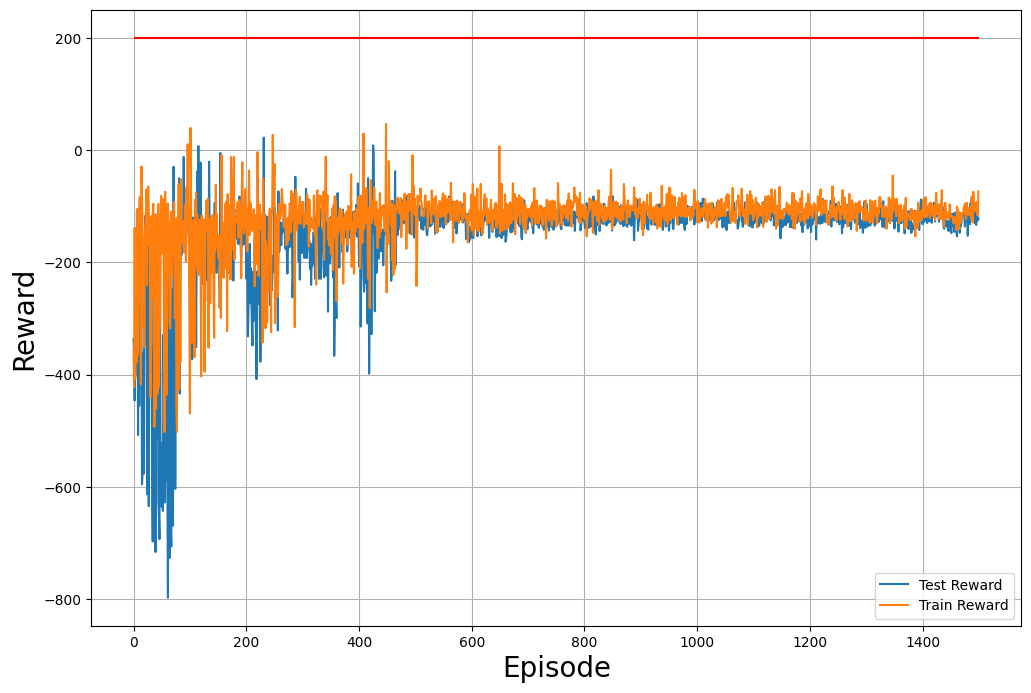

In [111]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()